In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2, chi2_fit, tau_R, tau_P
from unchanged_values import r, r_au, sD1_log, Ω, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [7]:
'''### Opacity ###
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 

    #Defining transition region
    def τ_R_func(T):
        a, b, c = [ 2.25221001e+00,  1.39416392e-02, -1.72380082e+03]
        return a * (1 - np.tanh((T + c) * b))
    
    Trans_i = np.where((TT >= 1500) & (TT <= 2000))
    κ[Trans_i] = τ_R_func(TT[Trans_i])
    
    κ[TT > 2000] = 0 # Støvet fordamper og går i stykker 

    return κ * (Σ.to('g/cm2')).value / 2, Trans_i


def tau_P(τ_R):
    τ_P = τ_R.copy()
    τ_P[2.4 * τ_P <= 0.5] = 0.5
    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]
    return τ_P'''

"### Opacity ###\ndef tau_R(T, Σ):\n    if type(T) != np.ndarray:\n        TT = (T.value).copy()\n    else:\n        TT = T.copy()\n    κ = np.zeros_like(TT)\n\n    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 \n\n    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 \n\n    #Defining transition region\n    def τ_R_func(T):\n        a, b, c = [ 2.25221001e+00,  1.39416392e-02, -1.72380082e+03]\n        return a * (1 - np.tanh((T + c) * b))\n    \n    Trans_i = np.where((TT >= 1500) & (TT <= 2000))\n    κ[Trans_i] = τ_R_func(TT[Trans_i])\n    \n    κ[TT > 2000] = 0 # Støvet fordamper og går i stykker \n\n    return κ * (Σ.to('g/cm2')).value / 2, Trans_i\n\n\ndef tau_P(τ_R):\n    τ_P = τ_R.copy()\n    τ_P[2.4 * τ_P <= 0.5] = 0.5\n    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]\n    return τ_P"

In [8]:
tau_R(T_req, Σ_initial(r_au))[1]

0.0

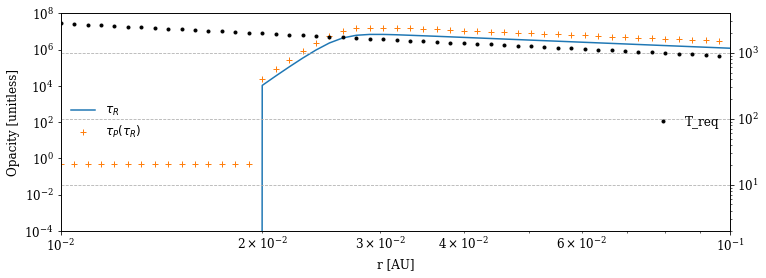

In [9]:
fig, axs = plt.subplots(figsize = (12,4))

axs.loglog(r_au, tau_R(T_req, Σ_initial(r_au)), '-', label = f'$τ_R$')
axs.loglog(r_au, tau_P(tau_R(T_req, Σ_initial(r_au))), '+', label = f'$τ_P(τ_R)$')
axs.set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8), xlim=(1e-2, 1e-1));
plt.legend(frameon = False, loc = 'center left')

axs2 = axs.twinx()

axs2.loglog(r_au, T_req,'.', c = 'black', label = 'T_req')
axs2.grid(ls='--')
axs2.legend(frameon = False, loc = 'center right')

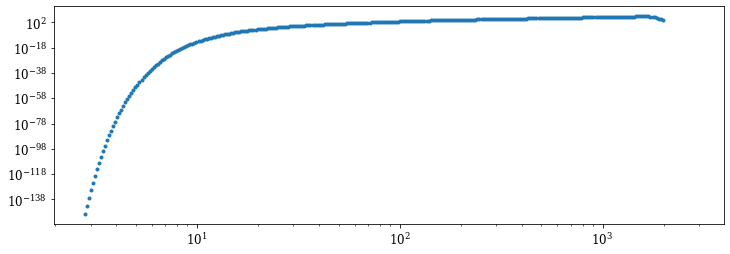

In [11]:
fig, axs = plt.subplots(figsize = (12,4))

axs.loglog(T_req, tau_R(T_req, Σ_initial(r_au)), '.', label = f'$τ_R$')


In [12]:
x = np.array([1400, 1500, 1650, 1700, 1800, 1900, 2000,])
y = np.array([4.5, 4.5, 4, 2.5, 1, 0, 0])
sigma_y = np.array([0.01, 0.01, 0.2, 0.2, 0.1, 0.01, 0.01])
def τ_R_func(T, a, b, c):
    return a * (1 - np.tanh((T + c) * b))

In [13]:
fit, value, error, cov, X, Y = chi2_fit(τ_R_func, x, y, sigma_y, np.array([4.5, 1e-2, -1400]))
print(fit, value)

[4.37494009e+01 4.00000000e+00 7.23258779e-09] [ 2.25221001e+00  1.39416392e-02 -1.72380082e+03]


Text(0.5, 0, 'T [K]')

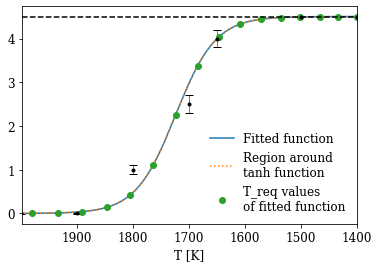

In [14]:
plt.errorbar(x, y, fmt='.', c='black', yerr = sigma_y, capsize = 4, elinewidth = 0.5)
plt.plot(X, Y, label = 'Fitted function')
t = np.arange(x[0], x[-1])

plt.plot(t, τ_R_func(t, *value), ls=':', label = 'Region around\ntanh function')
plt.plot(T_req, τ_R_func(T_req.value, *value), 'o', label = 'T_req values\nof fitted function')
plt.xlim(t[-1], t[0])
plt.axhline(4.5, ls='--', c = 'black')
plt.legend(frameon = False)
plt.xlabel('T [K]')

(1600.0, 1450.0)

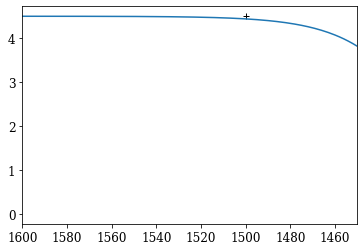

In [15]:
t = np.arange(1400, 1601)
plt.plot(x, y, '+', c='black')
plt.plot(t, 4.5 * np.tanh(40**(-1) * (t - 1400)))
plt.xlim(1600, 1450)

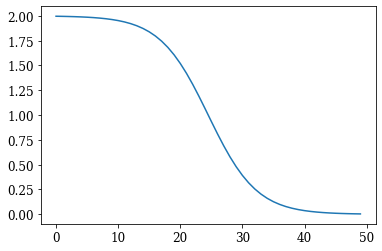

In [16]:
plt.plot(1-np.tanh(np.linspace(- np.pi, np.pi)))

### Making polynomium for $\kappa_R$ 

[Text(0, 0.5, 'Tau_R'), Text(0.5, 0, 'T_req')]

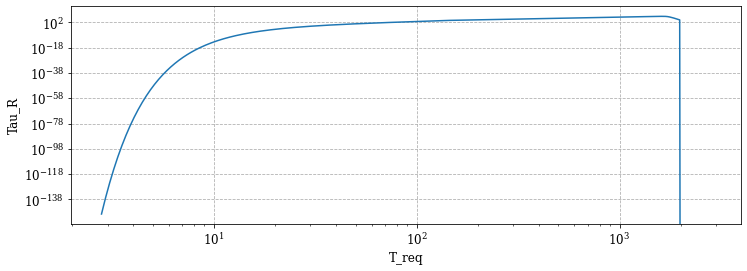

In [18]:
fig, axs = plt.subplots(figsize = (12,4))
axs.grid(ls = '--')
axs.loglog(T_req, tau_R(T_req, Σ_initial(r_au)))
axs.set(ylabel = 'Tau_R', xlabel = 'T_req')

array([ 2.25044588e+00,  1.55595715e-02, -1.49115216e+03])

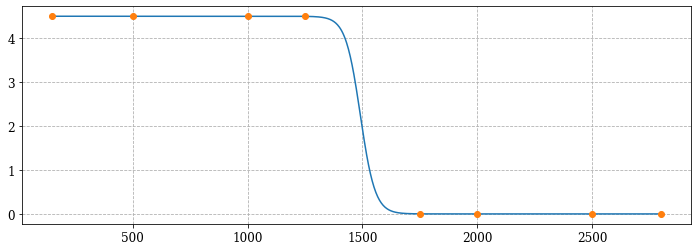

In [25]:
fig, axs = plt.subplots(figsize = (12,4))
axs.grid(ls = '--')
T_values = np.array([150, 500, 1000, 1250, 1750,  2000, 2500, 2800])
κ_r_values = np.array([4.5, 4.5, 4.5, 4.5, 0, 0, 0, 0, ])
sigma = 0.1
fit, value, error, cov, X, Y = chi2_fit(τ_R_func, T_values, κ_r_values, sigma, np.array([4.5, 1e-2, -1400]))
axs.plot(X, Y)
axs.plot(T_values, κ_r_values, 'o')
value

In [32]:
def kappa_R(T):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[TT >= 150] = τ_R_func(TT[TT >= 150], *value)

    return κ    

[(2799.999999999999, 2.7999999999999994),
 Text(0, 0.5, '$κ_R$'),
 Text(0.5, 0, 'T_req')]

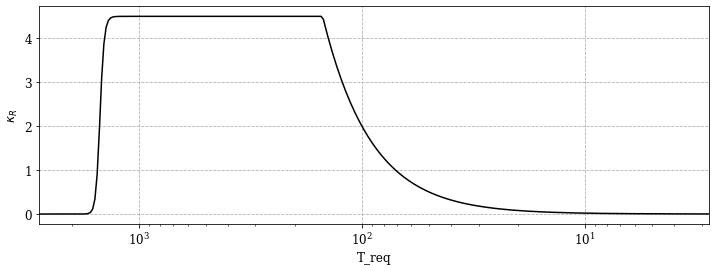

In [40]:
fig, axs = plt.subplots(figsize = (12,4))
axs.grid(ls = '--')
axs.semilogx(T_req, kappa_R(T_req), c = 'black')
axs.set(xlim = (T_req[0].value, T_req[-1].value), ylabel = '$κ_R$', xlabel = 'T_req')
